# **1. Settings**

1) Important required libraries

In [58]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
import utils

2) Hyperparameter

In [59]:
batch_size = 16 #64 #1
learning_rate = 0.0001
epoch = 20

n_node = 1024 # customized last layer의 노드 수. 64, 128, 256, 512, 1024
dropratio = 0.5 # 얼마나 드랍시킬지 inverse keepratio

imgsize = 256

# **2. Data Loader**

트레이닝 데이터

In [60]:
img_dir = "vegetable/train"
train_data = dset.ImageFolder(img_dir, transforms.Compose([
                                                           # 1-(512).3.2-RCrop <-- Best
                                                           transforms.CenterCrop(imgsize*2), # 1-CenterCrop(512)
                                                           transforms.RandomCrop(imgsize), # 2-RandomCrop
                                                           transforms.RandomHorizontalFlip(), # 3-Random HorizontalFlip

                                                           transforms.Resize(imgsize),
                                                           transforms.ToTensor()
]))
print(train_data.__len__())

train_batch = data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)

30


고정된 데이터 셋

In [61]:
# 2. Dev data
img_dir = "vegetable/dev"
dev_data = dset.ImageFolder(img_dir, transforms.Compose([
                                                         #transforms.Scale(256),
                                                         #transforms.RandomSizedCrop(224),

                                                         transforms.CenterCrop(size=imgsize),
                                                         transforms.Resize(imgsize),
                                                         transforms.ToTensor()
])) 
dev_batch = data.DataLoader(dev_data, batch_size=batch_size, shuffle=False, num_workers=2)

In [62]:
# 3. Test data
img_dir = "vegetable/test"
test_data = dset.ImageFolder(img_dir, transforms.Compose([
                                                          #transforms.Scale(256),
                                                         #transforms.RandomSizedCrop(224),

                                                         transforms.CenterCrop(size=imgsize),
                                                         transforms.Resize(imgsize),
                                                         transforms.ToTensor()
]))
test_batch = data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

In [63]:
nclass = len(train_data.classes)
print("# of classes: %d"%nclass)
print(train_data.classes)
print(train_data.class_to_idx)
print(train_data.__len__())

print("Training: %d, Dev: %d, Test: %d"
      %(train_data.__len__(), dev_data.__len__(), test_data.__len__())),

# of classes: 2
['cucumber', 'zucchini']
{'cucumber': 0, 'zucchini': 1}
30
Training: 30, Dev: 30, Test: 30


(None,)

In [64]:
print(train_data.classes)
print(dev_data.classes)
print(test_data.classes)

['cucumber', 'zucchini']
['cucumber', 'zucchini']
['cucumber', 'zucchini']


# **3. Model**

1) Pretrained VGG Model

In [65]:
vgg = models.vgg19(pretrained=True)

for name, module in vgg.named_children():
  print(name)

print(list(vgg.children())[0])
print(list(vgg.children())[-1])

features
avgpool
classifier
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(

In [66]:
print(list(vgg.children())[0][0])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


2) Customized Fully Model

In [67]:
base_dim = 64
fsize = int(imgsize/32)

class MyVGG(nn.Module):
    def __init__(self):
        super(MyVGG, self).__init__()
        # [0]: features(conv), [1]: classifier(fc)
        self.layer0 = nn.Sequential(*list(vgg.children())[0])

        self.layer1 = nn.Sequential(
            nn.Linear(8*base_dim * fsize * fsize, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),  # 0.3 만큼 drop 하자.

            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),

            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),

            nn.Linear(n_node, nclass),
        )
        # weigth initialization
        for m in self.layer1.modules():
            #print(m)
            if isinstance(m, nn.Conv2d):
              init.kaiming_normal(m.weight.data) # ReLU 일 때
              m.bias.data.fill_(0)
            if isinstance(m, nn.Linear):
              init.kaiming_normal(m.weight.data)
              m.bias.data.fill_(0)

    def forward(self, x):
        # layer0의 사이즈를 무식하게 프린트하여 알아낼 수 있음(batchsize, x,x,x)
        #print(x.size())
        out = self.layer0(x)
        out = out.view(out.size(0), -1)
        out = self.layer1(out)
        return out

3) Model on GPU

In [68]:
model = MyVGG().cuda()

for params in model.layer0.parameters():
  params.required_grad = False

for params in model.layer1.parameters():
  params.required_grad = True

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [69]:
for name in model.children():
  print(name)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

# **4. Optimizer & Loss**

In [70]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.layer1.parameters(), lr=learning_rate)

# **5. Train**

In [76]:
import utils

total_time = 0
disp_step = 10

to_train = True
if (to_train==False):
  netname = './nets/cumzuc_vgg19_10.pkl'
  model = torch.load(netname)
else:
  print("3 layer, n_node: %d, dropoutratio: %.2f" %(n_node, dropratio))
  model.eval() # evaluation(test) mode로 바꾸기 -> dropout, batch normalization에 영향을 줌.
  train_corr = utils.ComputeCorr(train_batch, model)
  dev_corr = utils.ComputeCorr(dev_batch, model)
  test_corr = utils.ComputeCorr(test_batch, model)
  print("Correct of train: %.2f, dev: %.2f, test: %.2f"
        %(train_corr, dev_corr, test_corr))
  model.train()

  netname = './nets/cumzuc_vgg19'

  # graph 그리기
  x_epoch = []
  y_train_err = []
  y_dev_err = []
  y_test_err = []

  x_epoch.append(0)
  y_train_err.append(100.0-train_corr)
  y_dev_err.append(100.0-dev_corr)
  y_test_err.append(100.0-test_corr)

    # # 학습을 재시작한다면
    # netname = 'nets/_.pkl'
    # model = torch.load(netname)
    # # 파라미터 학습 여부 결정
    # for params in model.layer0.parameters(): 
    #   params.required_grad = False
    # for params in model.layer1.parameters():
    #   params.required_grad = True
    # for i in range(34, epoch):

  # 재시작하지 않는다면
  for i in range(epoch):  
    start_time = time.time()
    print("%d.." %i),
    for img,label in train_batch:
      img = Variable(img).cuda()
      label = Variable(label).cuda()

      optimizer.zero_grad()
      output = model(img)
      loss = loss_func(output, label)
      loss.backward()
      optimizer.step()
    
    end_time = time.time()
    duration = end_time - start_time
    total_time += duration
    if (i % disp_step == 0) or (i == epoch-1):
      torch.save(model, netname+'_%d.pkl'%i, )
      print("\n[%d/%d] loss: %.3f, " %(i, epoch, (loss.cpu()).data.numpy())),

      # evaluation(test) mode로 바꾸기 -> dropout, batchnormalization에 영향을 줌.
      model.eval()

      # train, dev, train accr
      train_corr = utils.ComputeCorr(train_batch, model)
      dev_corr = utils.ComputeCorr(dev_batch, model)
      test_corr = utils.ComputeCorr(test_batch, model)
      print("Correct of train: %.2f, dev: %.2f, test: %.2f, "
            %(train_corr, dev_corr, test_corr)),
      model.train()
      print("time: %.2f sec.." %(total_time))

      # graph 그리기
      x_epoch.append(i+1)
      y_train_err.append(100.0-train_corr)
      y_dev_err.append(100.0-dev_corr)
      y_test_err.append(100.0-test_corr)
    print("Total time: %.2f sec" %total_time)

3 layer, n_node: 1024, dropoutratio: 0.50
Correct of train: 56.67, dev: 53.33, test: 50.00
0..

[0/20] loss: 0.442, 
Correct of train: 53.33, dev: 56.67, test: 60.00, 
time: 0.67 sec..
Total time: 0.67 sec
1..
Total time: 1.30 sec
2..
Total time: 1.99 sec
3..
Total time: 2.67 sec
4..
Total time: 3.35 sec
5..
Total time: 4.03 sec
6..
Total time: 4.72 sec
7..
Total time: 5.39 sec
8..
Total time: 6.07 sec
9..
Total time: 6.76 sec
10..

[10/20] loss: 0.650, 
Correct of train: 86.67, dev: 66.67, test: 80.00, 
time: 7.44 sec..
Total time: 7.44 sec
11..
Total time: 8.11 sec
12..
Total time: 8.83 sec
13..
Total time: 9.49 sec
14..
Total time: 10.17 sec
15..
Total time: 10.86 sec
16..
Total time: 11.53 sec
17..
Total time: 12.22 sec
18..
Total time: 12.93 sec
19..

[19/20] loss: 0.357, 
Correct of train: 76.67, dev: 70.00, test: 76.67, 
time: 13.64 sec..
Total time: 13.64 sec


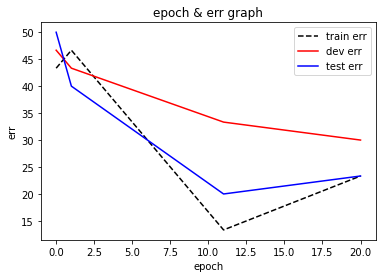

In [77]:
# epoch-err curve
if (to_train):
  plt.plot(x_epoch, y_train_err, color='black', label='train err', linestyle='--')
  plt.plot(x_epoch, y_dev_err, color='red', label='dev err')
  plt.plot(x_epoch, y_test_err, color='blue', label='test err')

  plt.xlabel('epoch')
  plt.ylabel('err')
  plt.title('epoch & err graph')
  plt.legend(loc="upper right")
  plt.show()

# **6. Evaluation for dev & test data**

Normalized confusion matrix


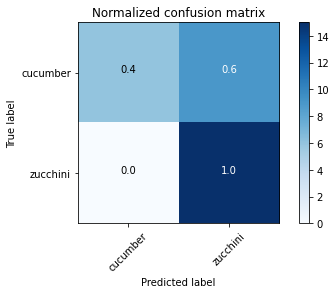

Confusion matrix, without normalization


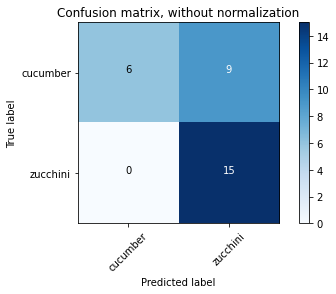

	 acc  |	 pre  |	 rec  |	 f1
 cucumber: 0.70 |	 1.00 |	 0.40 |	 0.57
 zucchini: 0.70 |	 0.62 |	 1.00 |	 0.77
*accuracy: 0.70, precision: 0.81, recall: 0.70, *f1 score: 0.67
[AP]
cucumber: 0.90
zucchini: 0.79

[mAP] 0.843
[miAP] 0.850


(array([0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1]),
 array([0.58678985, 0.90025347, 0.5865109 , 0.51790905, 0.76550263,
        0.60106522, 0.64482975, 0.61220801, 0.82857388, 0.62381226,
        0.84563774, 0.73172712, 0.5036298 , 0.84069574, 0.81678075,
        0.83263814, 0.86144042, 0.70020247, 0.66156721, 0.93275893,
        0.88267213, 0.68005759, 0.85299313, 0.85278255, 0.66348213,
        0.63597202, 0.88417488, 0.84128153, 0.7837919 , 0.80063456]))

In [78]:
model.eval() # evaluation(test)mode 로 바꾸기 -> dropout, batch normalization
utils.EvaluateClassifier(dev_batch, model, dev_data.classes, batch_size)

Normalized confusion matrix


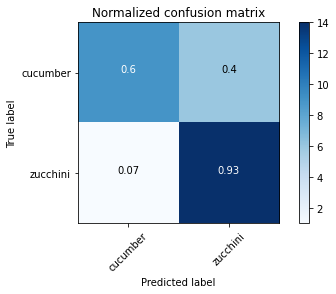

Confusion matrix, without normalization


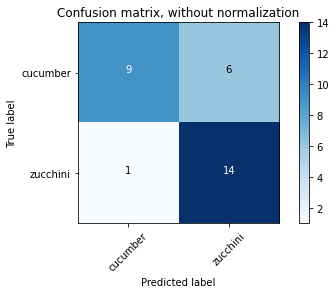

	 acc  |	 pre  |	 rec  |	 f1
 cucumber: 0.77 |	 0.90 |	 0.60 |	 0.72
 zucchini: 0.77 |	 0.70 |	 0.93 |	 0.80
*accuracy: 0.77, precision: 0.80, recall: 0.77, *f1 score: 0.76
[AP]
cucumber: 0.90
zucchini: 0.94

[mAP] 0.918
[miAP] 0.883


In [80]:
model.eval()
_, _,_ = utils.EvaluateClassifier(test_batch, model, test_data.classes, batch_size)

Category: cucumber
 True predicted images/total cucumber category: 6 / 15
Predicted probability:
[0.58678985 0.41321018]


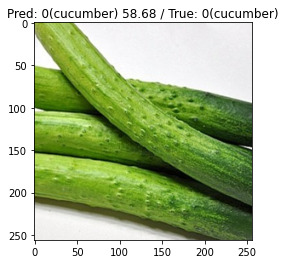

Predicted probability:
[0.51790905 0.48209095]


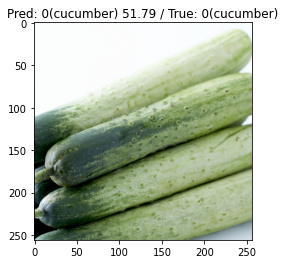

 False predicted images/total cucumber category: 9 / 15
Predicted probability:
[0.0997465 0.9002535]


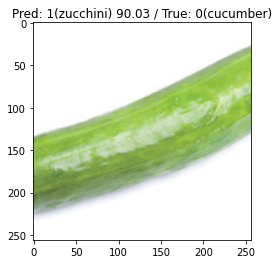

Predicted probability:
[0.41348907 0.5865109 ]


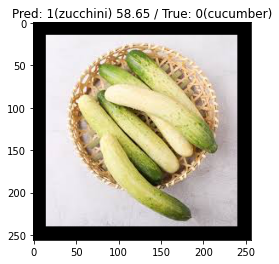

Category: zucchini
 True predicted images/total zucchini category: 15 / 15
Predicted probability:
[0.16736187 0.83263814]


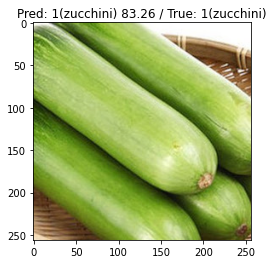

Predicted probability:
[0.1385596 0.8614404]


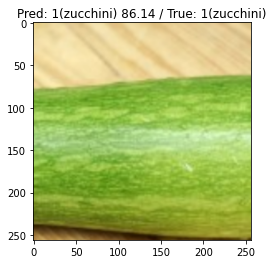

 False predicted images/total zucchini category: 0 / 15


In [81]:
utils.VisTFPred(dev_batch, model, test_data.classes, batch_size, i_n=2)